# Amazon Software Products Recommender System

>  we build several types of recommender systems, including a hybrid model to generate recommendations for software products for customers on amazon.

# Overview

In this project, we work with an amazon dataset which has product review information with over 12 000 reviews across over 800 software products on Amazon. THe goal of the project is develop three different types of recommender systems - collaborative filtering system, content based filtering system and a hybrid recommender system. Within each of these types of recommenders we may build one or more models. We also perform sentiment analysis to assess the emotion or feeling around a user's review. 

***We also consider using sentiment analysis to generate possible features to include in our recommender models***.


## Data

We use an **amazon product review dataset** made available in 2018. The dataset is an updated version of the ***Amazon review dataset*** released in 2014. As in the previous version, this dataset includes **reviews** (ratings, text, helpfulness votes), product **metadata** (descriptions, category information, price, brand, and image features). We shall make use of a smaller subset of the original data. Specifically, we have the amazon product review dataset for software products only! For more information look at the dataset [homepage](https://nijianmo.github.io/amazon/index.html). 

    The dataset has over 12 000 customer reviews and has over 800 software products sold on Amazon.


## Model Evaluations and Metrics

There are a variety of metrics we can use to assess our models. Some of which are given below (which we shall use):

- ***Root Mean Squared Error (RMSE)***: This is a common metric used in collaborative filtering to evaluate the accuracy of the predicted ratings. You can calculate the RMSE by comparing the predicted ratings to the actual ratings in the dataset.

- ***Coverage***: This metric measures the percentage of unique items that are recommended to at least one user. A higher coverage indicates that the recommender system is able to recommend a wider variety of items to users.

- ***Diversity***: This metric measures the diversity of the recommendations, and is used to ensure that the recommender system is not always recommending the same set of items to all users. A higher diversity indicates that the recommender system is able to recommend a wider variety of items to different users.


# Setup and Data Loading

We begin by loading the packages for this project. We then load the datasets with our product reviews and product metadata. We then seek to merge them. 

In [317]:
# get modules 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [318]:
# read in data
soft_data = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/Software_5.json',lines=True)

# view data
display(soft_data.head(3))
print("shape of Data:", soft_data.shape)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN


shape of Data: (12805, 12)


By setting `lines=True`, `pandas.read_json()` reads the JSON file line by line, treating each line as a separate JSON object. This is useful when you have a file that contains multiple JSON objects, each on a separate line, as is often the case with log files or other data sources that generate JSON data.



In [319]:
# structure
soft_data.dtypes

# trim data 
soft_data = soft_data[[ 'reviewerID', 'reviewerName', 'asin', 'reviewText', 'overall']]

# see new data
soft_data.head(5)

,reviewerID,reviewerName,asin,reviewText,overall
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5
3,AYUF7YETYOLNX,Bryan Newman,0321719816,I've been creating websites with Dreamweaver f...,5
4,A31ICLWQ9CSHRS,Al Swanson,0321719816,I decided (after trying a number of other prod...,5


In [320]:
# read in metadata
meta = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/meta_Software.json',lines=True)

# remove irrelevant columns
meta = meta[['asin', 'title', 'description', 'brand', 'price']]
meta.head(8)

,asin,title,description,brand,price
0,0030672120,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],HOLT. RINEHART AND WINSTON,.a-box-inner{background-color:#fff}#alohaBuyBo...
1,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...","[, <b>Latin rhythms that will get your kids si...",McGraw Hill,
2,007329506X,Connect with LearnSmart Access Card for Microb...,[<b>Connect is the only integrated learning sy...,McGraw-Hill Science/Engineering/Math,
3,0073513458,LearnSmart Standalone Access Card for Prescott...,[],McGraw-Hill Education,
4,0073525758,Anatomy &amp; Physiology Revealed Student Acce...,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,McGraw-Hill Education,$4.83
5,0077340701,Connect Math by ALEKS Access Card 52 Weeks for...,"[John Coburn grew up in the Hawaiian Islands, ...",McGraw-Hill Science/Engineering/Math,
6,0077369823,Connect Access Card for Microbiology Fundament...,[<b>Connect is the only integrated learning sy...,Brand: McGraw-Hill Science/Engineering/Math,
7,0077410297,Connect Art with McGraw-Hill LearnSmart Access...,[<i>Living with Arts </i> approach to art appr...,McGraw-Hill Humanities/Social Sciences/Languages,


In [321]:
# merge the data
soft_data = pd.merge(soft_data, softmeta_data[['asin', 'title', 'description', 'brand']], on='asin')

# view merged dataframe
soft_data.head(10)

,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
3,AYUF7YETYOLNX,Bryan Newman,0321719816,I've been creating websites with Dreamweaver f...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
4,A31ICLWQ9CSHRS,Al Swanson,0321719816,I decided (after trying a number of other prod...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
5,A2BVNVJOFXGZUB,J. Howard,0321719816,The video is well-paced and delivered in an un...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
6,A2JMJVNTBL7K7E,Yesuaini99,0321719816,I spent several hours on the lesson and I love...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
7,A14JBDSWKPKTZA,Bob Feeser,0321719816,I have had Dreamweaver MX2004 since it came ou...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
8,A2WCFDOCS73PNB,Gadgetman,0321719816,I have also taken a local community college on...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
9,A14638TGYH7GD9,Rebecca Haden,0321719816,Even though I use Dreamweaver a great deal and...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press


***
# Data Exploration

In [322]:
# descriptive statistics for ratings
soft_data['overall'].describe()

count    14103.00000
mean         3.94214
std          1.35304
min          1.00000
25%          3.00000
50%          4.00000
75%          5.00000
max          5.00000
Name: overall, dtype: float64

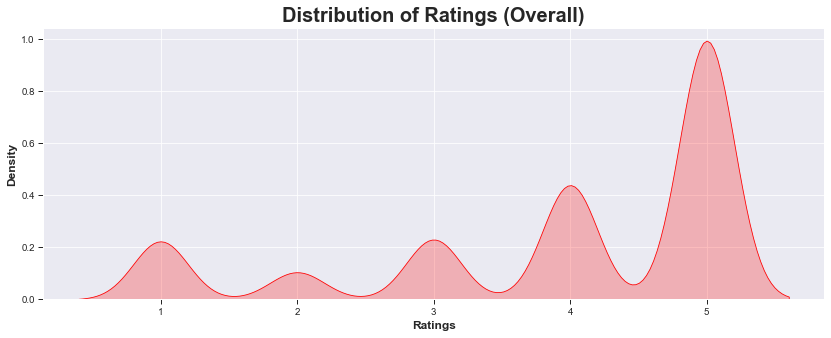

In [323]:
fig = plt.figure(figsize=(14,5))
sns.set_context("paper",font_scale=1.1)

ax = sns.kdeplot(soft_data['overall'],
                 color="Red", shade = True)
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_xlabel('Ratings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Ratings (Overall)', fontsize=20, fontweight='bold');

In [324]:
# How many customers
print("Number of Customers:", soft_data.reviewerID.unique().size)

# Count Reviews and Average Rating per Customer
cust_data = soft_data.groupby(['reviewerID']).agg({"overall": ["count", "mean"]})
cust_data.columns = ['count_rev', 'mean_rat']
cust_data['mean_rat'] = np.round(cust_data.mean_rat,3)
display(cust_data2222.head(4))

Number of Customers: 1826


,count_rev,mean_rat
reviewerID,,
A100UD67AHFODS,5,4.80
A105S56ODHGJEK,29,3.69
A1075X1Q4M3S78,5,5.00
A10C5CJK1YKGV0,10,4.10


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

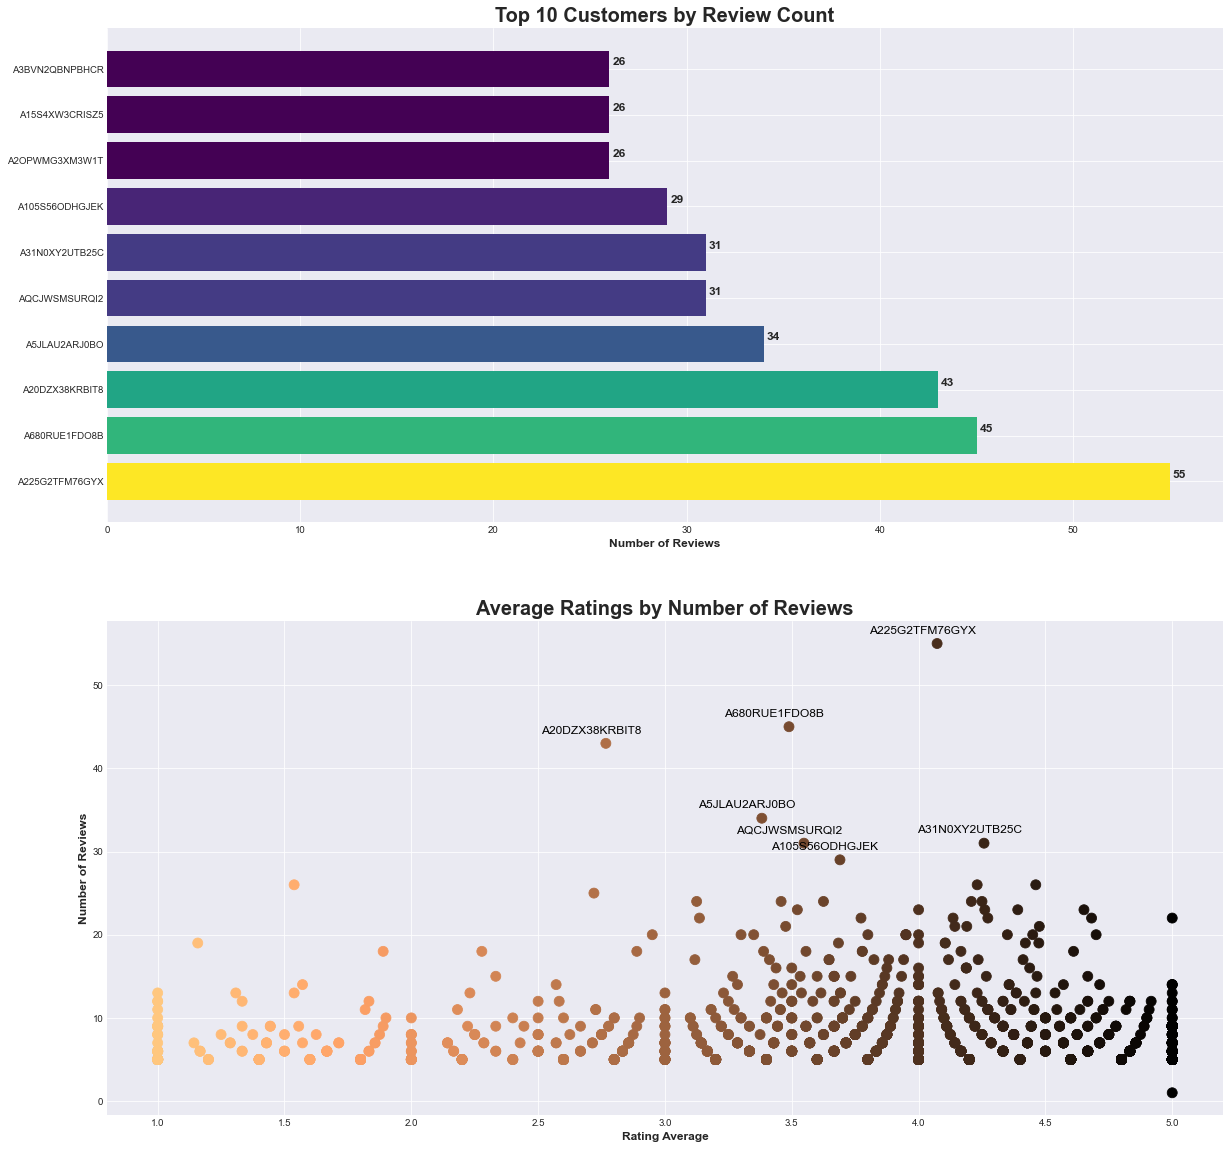

In [325]:
# Plot of Most - bar plot
plt.style.use('seaborn-darkgrid')
sample_top = cust_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average


fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews - scatter plot
plt.subplot(2, 1, 2)
plt.scatter(cust_data.mean_rat, cust_data.count_rev, c=cust_data.mean_rat, cmap='copper_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data.index):
    if (cust_data.count_rev[i] > 26):
        plt.annotate(id, (cust_data.loc[cust_data.index==id, "mean_rat"], cust_data.loc[cust_data.index==id, "count_rev"]), textcoords="offset points", xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')


In [326]:
# How many items/products?
print("Number of Products:", soft_data.asin.unique().size)

# Number reviews and average ratings per product
prod_data = soft_data.groupby(['asin']).agg({"overall": ["count", "mean"]})
prod_data.columns = ['count_rev', 'mean_rat']
prod_data['mean_rat'] = np.round(prod_data.mean_rat,3)
display(prod_data.head(4))

Number of Products: 802


,count_rev,mean_rat
asin,,
0321700945,8,4.750
0321719816,14,4.571
0321719824,9,4.222
0763855553,36,4.028


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

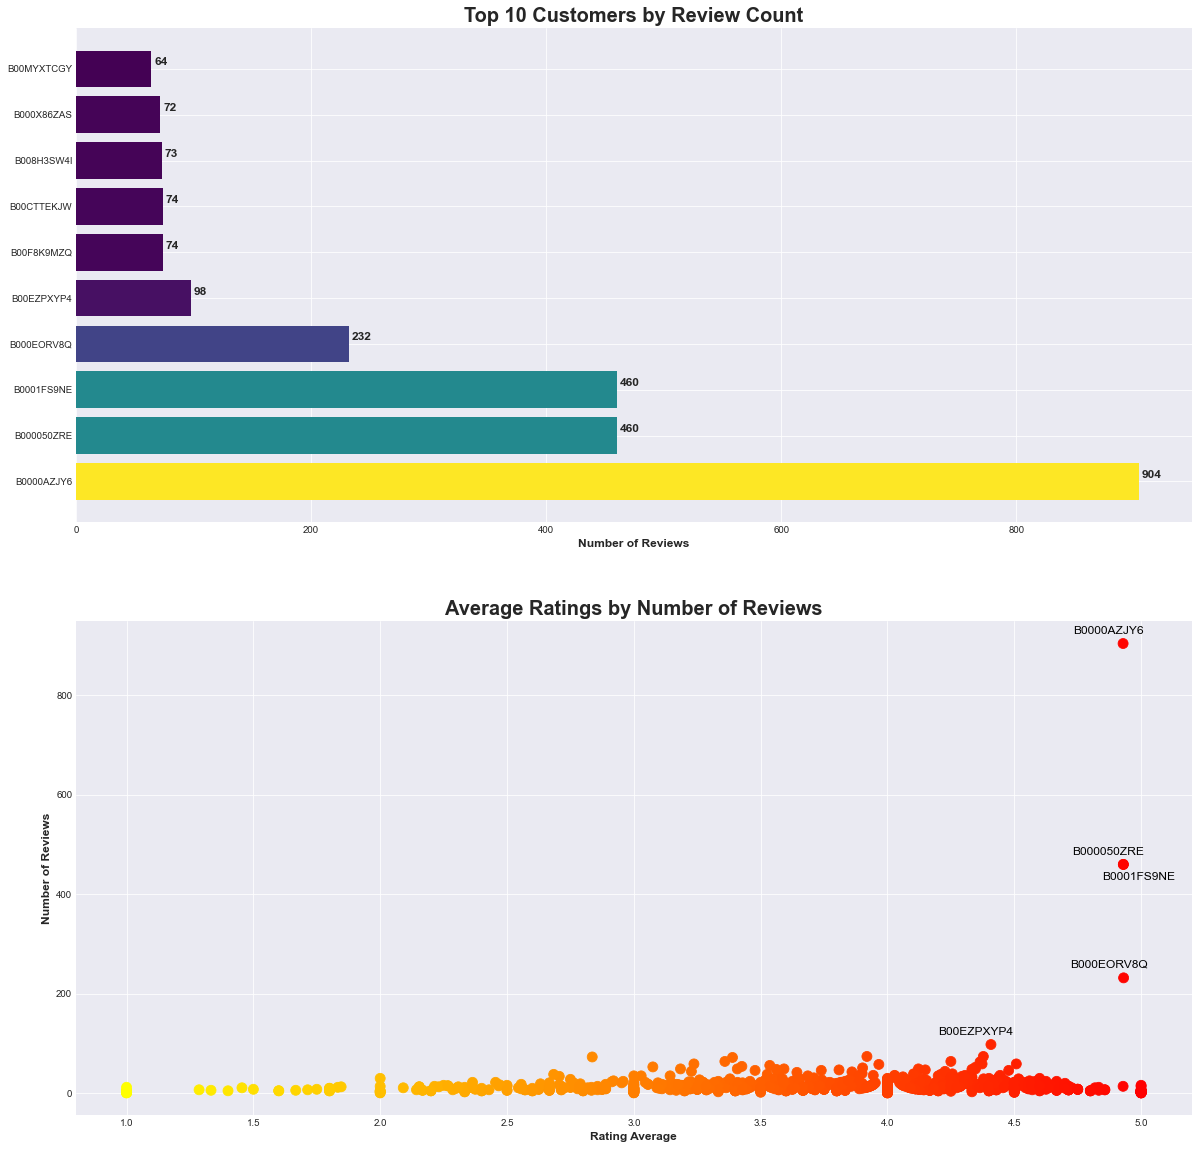

In [327]:
# Plot of Most / Fewest Reviews 
plt.style.use('seaborn-darkgrid')
sample_top = prod_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average

fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews
plt.subplot(2, 1, 2)
plt.scatter(prod_data.mean_rat, prod_data.count_rev, c=prod_data.mean_rat, cmap='autumn_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(prod_data.index):
    if (prod_data.count_rev[i] >= 98):
        if id == 'B0001FS9NE':
            xytext = (15, -15)
        else: xytext=(-15,10)
        plt.annotate(id, (prod_data.loc[prod_data.index==id, "mean_rat"], prod_data.loc[prod_data.index==id, "count_rev"]), textcoords="offset points",xytext=xytext, ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')

***
# Data Cleaning

We are to clean our text features in our dataset, so as to prepare it for further analysis. This includes removing all punctuation marks, whitespace, make all text lowercase, and remove stop words as well as numbers if irrelevant. Specifically, we are interested in cleaning the following columns or features:

- ***reviewText***
- ***title***
- ***description***


More so we are interested in seeing if there is any **missing data** in the columns of interest and decide if imputation is necessary. Also we want to ensure the **data types** are correct for all the features. Finally, we want to ensure there are no **duplicated data**. 


 There are missing values in the data.


,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand
5279,A1VQHH85U7PX0,NaN,B001EHXOFG,"Nowadays, I have grown to be very dependant on...",4,Microsoft Streets &amp; Trips 2009 [OLD VERSION],[NEW&#8212;Entertainment online&#8217;s FREE t...,Microsoft
5503,A1VQHH85U7PX0,NaN,B001TYYZCA,I used Corel Painter X before upgrading to Cor...,3,Corel Painter 11 [OLD VERSION],[Corel Painter 11 is the ultimate art studio f...,Corel
6012,A1VQHH85U7PX0,NaN,B002JB3CUS,PaperPort is a very helpful tool for reducing ...,4,"PaperPort 12 [Old Version]"" />",[Overwhelmed by paperwork? Feeling disorganize...,Nuance Dragon
6210,A1VQHH85U7PX0,NaN,B0039Y58YC,WordPerect X5 is an office suite consisting of...,5,WordPerfect Office X5 Standard [Old Version],"[Create great-looking documents, spreadsheets ...",Corel
9232,A1VQHH85U7PX0,NaN,B00CTTEKJW,I finally caved to Amazon's relentless efforts...,4,Amazon Music [PC] [Download],"[<table border=""0"" cellpadding=""5"" cellspacing...",Amazon Digital Services LLC



 Columns with Missing Data:
 reviewerID      0
reviewerName    9
asin            0
reviewText      1
overall         0
title           0
description     0
brand           0
dtype: int64


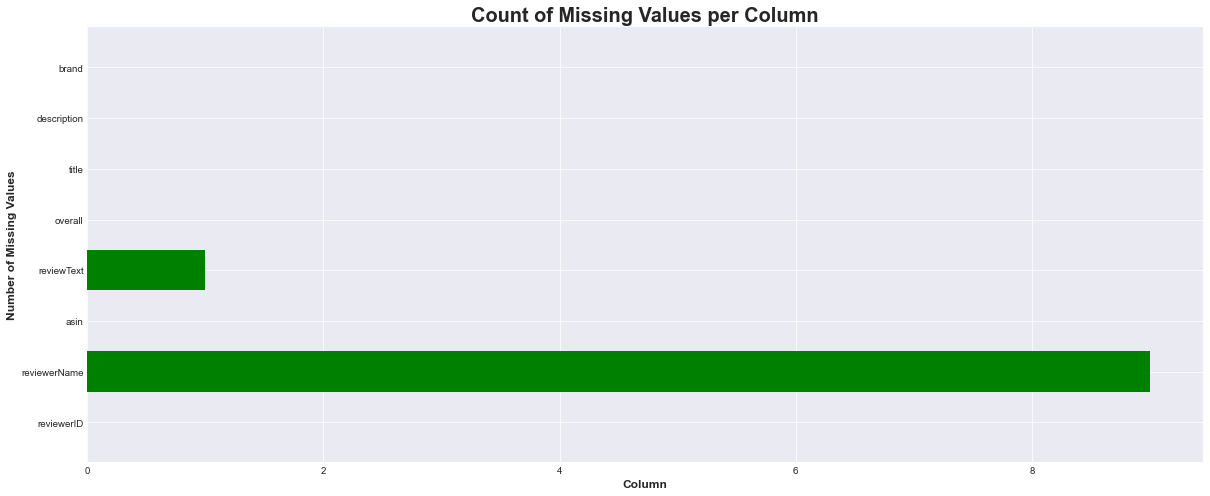

In [328]:
# check if any of the columns have missing values
is_na = soft_data.isna().any().any()

# if there are NA values in columns -> show rows, show number of NAs per column
if is_na:
    print("\n There are missing values in the data.")
    display(soft_data[soft_data.isna().any(axis=1)].head(5))
    print("\n Columns with Missing Data:\n", soft_data.isna().sum())
    missing_values_count = soft_data.isna().sum()
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(20, 8))
    plt.barh(y=missing_values_count.index, width=missing_values_count.values, color="green")
    plt.xlabel("Column", fontsize=12, fontweight='semibold')
    plt.ylabel("Number of Missing Values", fontsize=12, fontweight='semibold')
    plt.title("Count of Missing Values per Column", fontsize=20, fontweight='bold')
    plt.show()

else:
    print("There are no missing values in the data.")

In [329]:
# remove rows with missing values for reviewerName
remove_ind = soft_data.loc[soft_data.isna().any(axis=1), 'reviewerName'].index
soft_data.drop(remove_ind, inplace=True)

# fill in missing values
soft_data.loc[soft_data.isna().any(axis=1), "reviewText"] = ""

# check for missing data
is_na = soft_data.isna().any().any()
if is_na: print("\n There are missing values in the data.")
else: print("There are no missing values in the data.")

There are no missing values in the data.


In [330]:
# make sure columns are text (strings)
soft_data['reviewText'] = soft_data['reviewText'].astype(str)
soft_data['title'] = soft_data['title'].astype(str)
soft_data['description'] = soft_data['description'].astype(str)
soft_data['brand'] = soft_data['brand'].astype(str)

# replace [] with title column
soft_data['description'] = soft_data['description'].str.replace(r'\[\]', '', regex=True)
mask = soft_data['description'] == ''
soft_data.loc[mask, 'description'] = soft_data.loc[mask, 'title'].fillna('')

In [331]:
# find any duplicate rows
soft_data.duplicated().any()

# show duplicate rows
soft_data[soft_data.duplicated()]

# remove duplicate rows
soft_data.drop_duplicates(inplace=True)

In [332]:
# load packages
import re

# function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Clean text data
soft_data['new_review'] = soft_data['reviewText'].apply(clean_text)
soft_data['new_title'] = soft_data['title'].apply(clean_text)
soft_data['new_desc'] = soft_data['description'].apply(clean_text)
soft_data['new_brand'] = soft_data['brand'].apply(clean_text)
soft_data.head(10)[['new_review', 'new_title', 'new_desc', 'new_brand']]

,new_review,new_title,new_desc,new_brand
0,i ve been using dreamweaver and it s predecess...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
1,the demo is done with the pc version with refe...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
2,if you ve been wanting to learn how to create ...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
3,i ve been creating websites with dreamweaver f...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
4,i decided after trying a number of other produ...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
5,the video is well paced and delivered in an un...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
6,i spent several hours on the lesson and i love...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
7,i have had dreamweaver mx2004 since it came ou...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
8,i have also taken a local community college on...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
9,even though i use dreamweaver a great deal and...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press


The code defines a function called `clean_text` that takes in a string `text` as input and returns the cleaned version of the string.

Here's a breakdown of what each line of the function does:

1. `text = text.lower()`: This line converts all uppercase characters in the string to lowercase. This step is usually performed in natural language processing to ensure that uppercase and lowercase versions of the same word are treated as the same.

2. `text = re.sub(r'[^a-zA-Z0-9]', ' ', text)`: This line uses the `re` module (short for regular expressions) to substitute any non-alphanumeric characters in the string with a space. The regular expression `[^a-zA-Z0-9]` matches any character that is not a letter or a number.

3. `text = re.sub(r'\s+', ' ', text)`: This line uses the re module to replace any sequences of one or more whitespace characters (such as spaces or tabs) with a single space.

4. `text = text.strip()`: This line removes any leading or trailing whitespace from the string.

5. `return text`: This line returns the cleaned version of the string.

Overall, this function is useful for cleaning up unstructured text data by removing non-alphanumeric characters and normalizing the case of the text. It can be used as a preprocessing step before performing tasks like sentiment analysis, topic modeling, or text classification.

***
# Sentiment Analysis

Sentiment analysis is the study of the emotional content of a body of text. 

- We shall look briefly at sentiment lexicons. 
- We shall then aggregating sentiments over words to assess sentiments of longer texts. 
- We shall also look at handling “negation” words like “not” that affect sentiment

### Sentiment Lexicons

One way of approaching the problem is to **assess the sentiment of individual words**, and then aggregate the sentiments of the words in a body of text in some way. For example, if we can classify whether each word is positive, negative, or neutral, we can count up the number of positive, negative, and neutral words in the document and define that as the sentiment of the document. This is just one way - a particularly simple way - of doing document-level sentiment analysis.

When assessing the sentiment or emotional content of individual words, we usually make use of **existing sentiment dictionaries (or “lexicons”)** that have already done this using some kind of manual classification.

> The gist is that we are dealing with a specific, pre-defined vocabulary.

> The goal is usually to assign a sentiment score to a text, possibly an overall score, or a generally positive or negative grade

***TLDR; Lexicons are dictionaries or lists that contain words with their corresponding positive or negative polarity scores***

We shall use three different lexicons:

1. **Bing**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.
2. **NRC**: a lexicon of English words with their corresponding scores on eight different emotions: anger, fear, anticipation, trust, surprise, sadness, joy, and disgust.
3. **AFINN**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.


In [333]:
# read lexicons in
afinn = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Afinn.csv')
bing = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Bing.csv')
nrc = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/NRC.csv')


In [334]:
# AFINN
print("Shape of AFINN:", afinn.shape)
print("Unique Sentiments:", afinn.value.unique())
display(afinn.head(5))

# BING
print("Shape of Bing:", bing.shape)
print("Unique Sentiments:", bing.sentiment.unique())
display(bing.head(5))

# NRC
print("Shape of NRC:", nrc.shape)
print("Unique Sentiments:", nrc.sentiment.unique())
display(nrc.head(5))


Shape of AFINN: (2477, 2)
Unique Sentiments: [-2 -3  2  1 -1  3  4 -4 -5  5  0]


,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


Shape of Bing: (6786, 2)
Unique Sentiments: ['negative' 'positive']


,word,sentiment
0,faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative


Shape of NRC: (13901, 2)
Unique Sentiments: ['trust' 'fear' 'negative' 'sadness' 'anger' 'surprise' 'positive'
 'disgust' 'joy' 'anticipation']


,word,sentiment
0,abacus,trust
1,abandon,fear
2,abandon,negative
3,abandon,sadness
4,abandoned,anger


### Review text by Customers

We look at the text of the reviews as a whole and calculate the sentiments for each review. This is done by using sentiment lexicons and breaking each review up into its constituent words and attaching a sentiment score to each word. We then sum of the sentiment scores for each word in a review and get the total sentiment for that review. This is done for all reviews. 

In [335]:
# Load AFINN
from afinn import Afinn

# Load the AFINN dictionary
afinn = Afinn()

# Define a function to calculate the sentiment score of each review
def get_sentiment_afinn(review):
    # Split the review into words
    words = review.split()
    # Calculate the sentiment score of each word using AFINN and sum the scores
    sentiment_score = sum(afinn.score(word) for word in words)
    return sentiment_score

# Apply the function to the 'review' column of your DataFrame
soft_data['sentiment_afinn'] = soft_data['new_review'].apply(get_sentiment_afinn)
soft_data[['new_review', 'sentiment_afinn']].head(10)

,new_review,sentiment_afinn
0,i ve been using dreamweaver and it s predecess...,17.0
1,the demo is done with the pc version with refe...,12.0
2,if you ve been wanting to learn how to create ...,47.0
3,i ve been creating websites with dreamweaver f...,26.0
4,i decided after trying a number of other produ...,18.0
5,the video is well paced and delivered in an un...,3.0
6,i spent several hours on the lesson and i love...,19.0
7,i have had dreamweaver mx2004 since it came ou...,13.0
8,i have also taken a local community college on...,14.0
9,even though i use dreamweaver a great deal and...,19.0


The command `afinn.score(word)` returns the sentiment score of the word based on the **AFINN** dictionary. The sentiment score of each review is calculated by summing the sentiment scores of all the words in the review. The resulting sentiment scores are stored in a new `'sentiment_afinn'` column of the DataFrame.

In [336]:
# load packages for BING
from textblob import TextBlob

# function to calculate sentiment using bing
def get_sentiment_bing(text):
    sentiment = 0
    blob = TextBlob(text, analyzer=PatternAnalyzer())
    for sentence in blob.sentences:
        for word in sentence.words:
            polarity = TextBlob(word, analyzer=PatternAnalyzer()).sentiment.polarity
            if polarity > 0:
                sentiment += 1
            elif polarity < 0:
                sentiment -= 1
    return sentiment

# run function on reviews
soft_data['sentiment_bing'] = soft_data['new_review'].apply(get_sentiment_bing)
soft_data[['new_review', 'sentiment_bing']].head(10)

,new_review,sentiment_bing
0,i ve been using dreamweaver and it s predecess...,11
1,the demo is done with the pc version with refe...,-6
2,if you ve been wanting to learn how to create ...,24
3,i ve been creating websites with dreamweaver f...,18
4,i decided after trying a number of other produ...,7
5,the video is well paced and delivered in an un...,3
6,i spent several hours on the lesson and i love...,11
7,i have had dreamweaver mx2004 since it came ou...,16
8,i have also taken a local community college on...,8
9,even though i use dreamweaver a great deal and...,9


> does sentiment analysis for all reviews using the Bing lexicon

This code defines a function `get_sentiment_bing()` that takes a text as input and returns its sentiment using the Bing lexicon. The function first creates a `TextBlob` object with the `PatternAnalyzer()` as the analyzer. It then iterates through each word in each sentence of the text, and uses the `TextBlob` object to get the polarity of each word. If the polarity is positive, the sentiment value is incremented by 1, and if it's negative, the sentiment value is decremented by 1. Finally, the function returns the sentiment value.

The last line of the code applies this function to the `'new_review'` column of the `'soft_data'` dataframe, and stores the sentiment value in a column. This will give you a new dataframe with a sentiment score for each review.

In [369]:
# Number reviews and sentiment per customer
cust_data = soft_data.groupby(['reviewerID']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
cust_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
cust_data = np.round(cust_data, 2)

# Number reviews and sentiment per product
prod_data = soft_data.groupby(['asin']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
prod_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
prod_data = np.round(prod_data, 2)

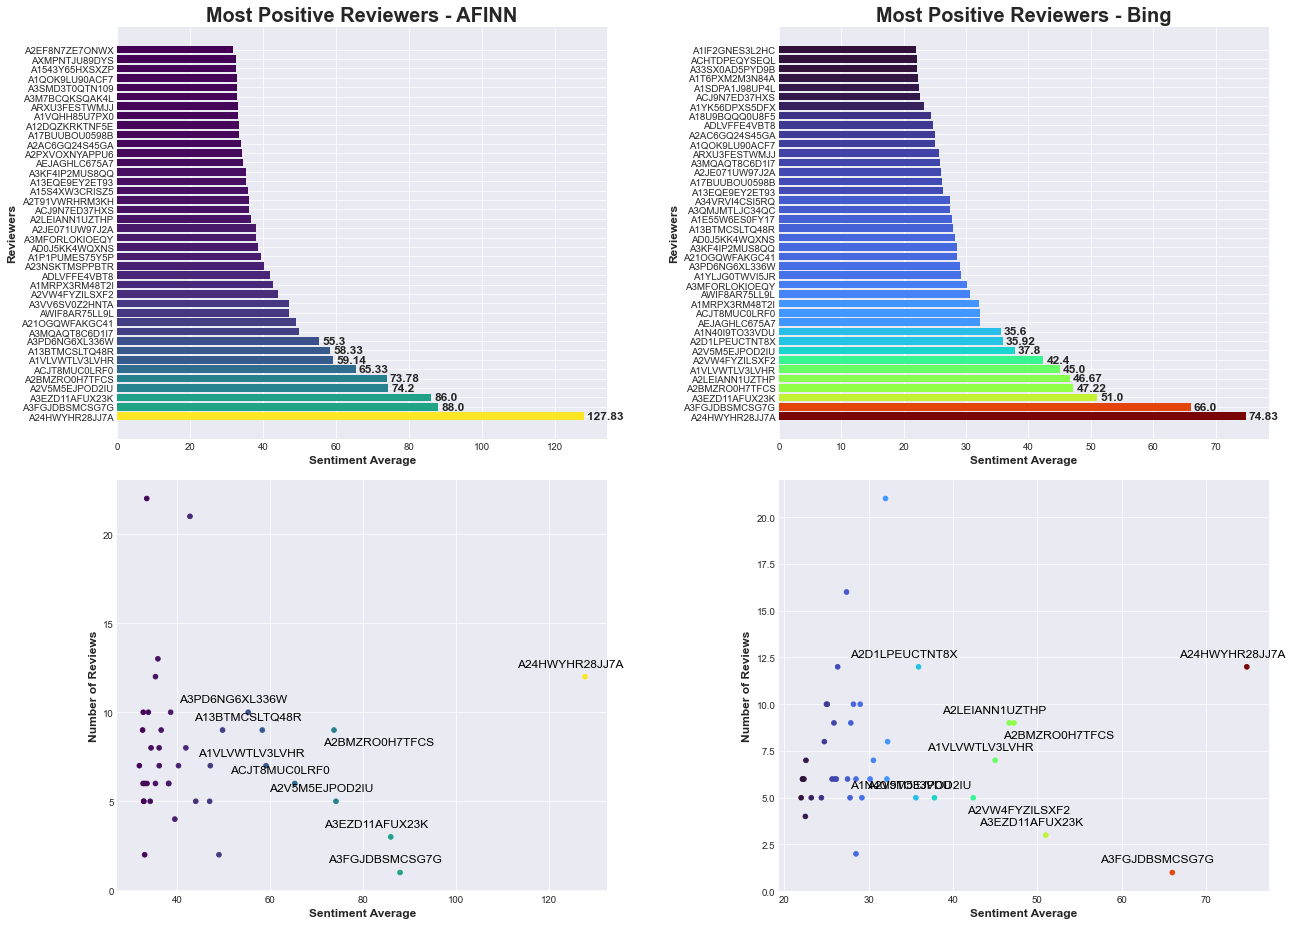

In [370]:
# Use a stylesheet
plt.style.use('seaborn-darkgrid')


# create figure
fig = plt.figure(figsize=(20, 15))


# Most Positive - AFINN
cust_data1 = cust_data.sort_values(['mean_sent_afinn'], ascending=False)
cust_data1 = cust_data1.head(40)
sent_min = cust_data1.mean_sent_afinn.min() 
sent_max = cust_data1.mean_sent_afinn.max()
sent_norm = (cust_data1.mean_sent_afinn - sent_min) / (sent_max - sent_min) 
colors_afinn = cm.viridis(sent_norm) 

plt.subplot(2, 2, 1)
bar = plt.barh(y=cust_data1.index, width=cust_data1.mean_sent_afinn, color=colors_afinn)
plt.title("Most Positive Reviewers - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height > 50:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)
    else: continue


plt.subplot(2, 2, 3)
plt.scatter(cust_data1.mean_sent_afinn, cust_data1.count_rev, c=colors_afinn, cmap='viridis')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data1.index):
    if cust_data1.mean_sent_afinn[i] > 50:
        if id == "A2BMZRO0H7TFCS":
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_afinn"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_afinn"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

    else: continue

# Most Positive - BING
cust_data1 = cust_data.sort_values(['mean_sent_bing'], ascending=False).head(40)
sent_min = cust_data1.mean_sent_bing.min()
sent_max = cust_data1.mean_sent_bing.max()
sent_norm = (cust_data1.mean_sent_bing - sent_min) / (sent_max - sent_min) 
colors_bing = cm.turbo(sent_norm) 

plt.subplot(2, 2, 2)
bar = plt.barh(y=cust_data1.index, width=cust_data1.mean_sent_bing, color=colors_bing)
plt.title("Most Positive Reviewers - Bing", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height > 35:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)
    else: continue


plt.subplot(2, 2, 4)
plt.scatter(cust_data1.mean_sent_bing, cust_data1.count_rev, c=colors_bing, cmap='turbo')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data1.index):
    if cust_data1.mean_sent_bing[i] > 35:
        if (id == "A2BMZRO0H7TFCS") or (id == "A2VW4FYZILSXF2"):
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_bing"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_bing"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
    

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.1)


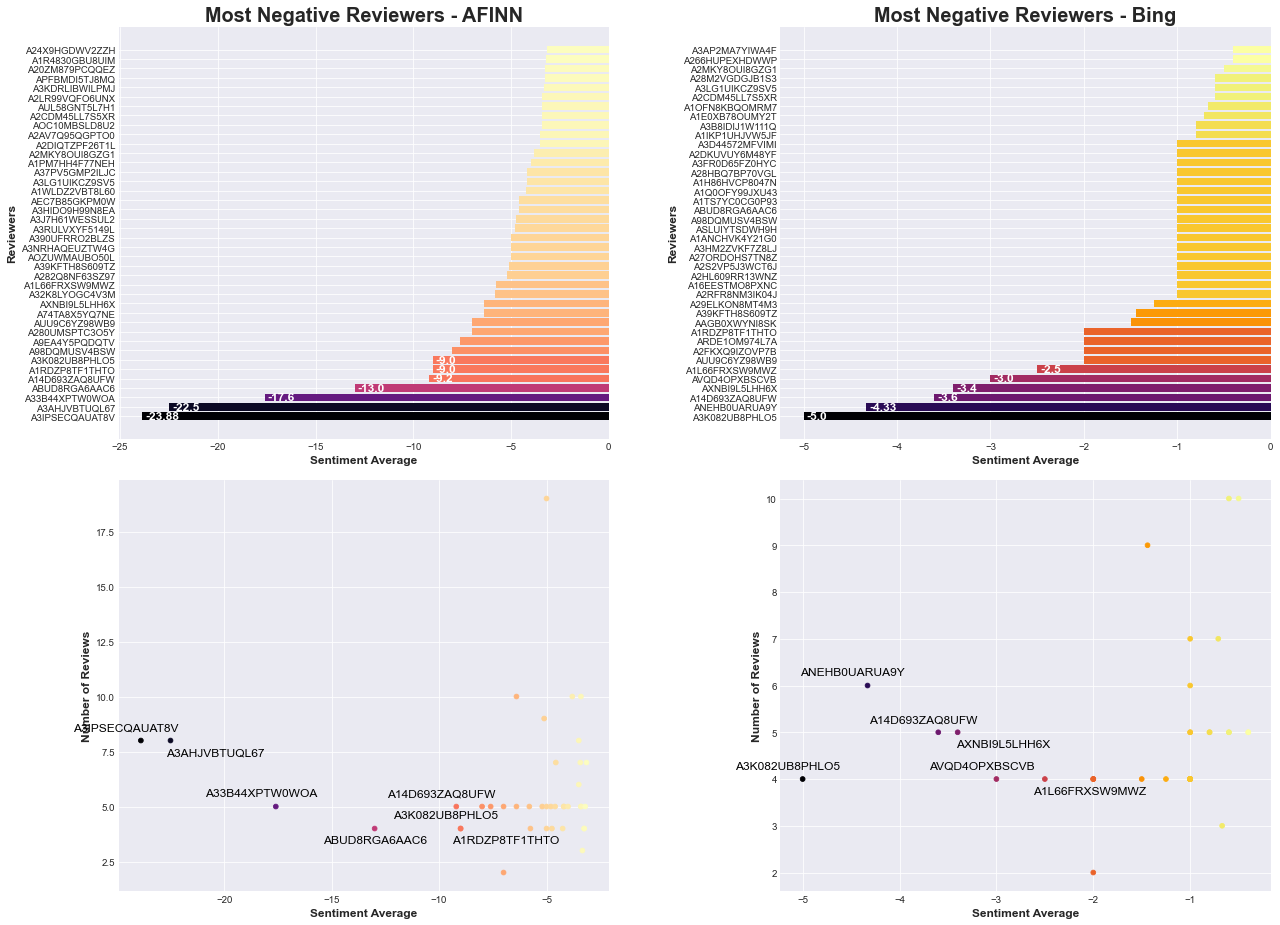

In [385]:
# Least Positive Reviewers - Bar Chart (AFINN and BING)

# Use a stylesheet
plt.style.use('seaborn-darkgrid')


# create figure
fig = plt.figure(figsize=(20, 15))


# Most Positive - AFINN
cust_data2 = cust_data.sort_values(['mean_sent_afinn'], ascending=True)
cust_data2 = cust_data2.head(40)
sent_min = cust_data2.mean_sent_afinn.min() 
sent_max = cust_data2.mean_sent_afinn.max()
sent_norm = (cust_data2.mean_sent_afinn - sent_min) / (sent_max - sent_min) 
colors_afinn = cm.magma(sent_norm) 

plt.subplot(2, 2, 1)
bar = plt.barh(y=cust_data2.index, width=cust_data2.mean_sent_afinn, color=colors_afinn)
plt.title("Most Negative Reviewers - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height < -8:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12, 
                color = 'white')
    else: continue


plt.subplot(2, 2, 3)
plt.scatter(cust_data2.mean_sent_afinn, cust_data2.count_rev, c=colors_afinn, cmap='magma')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data2.index):
    if cust_data2.mean_sent_afinn[i] < -8:
        if (id == "A3AHJVBTUQL67") or (id == "A1RDZP8TF1THTO") :
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        elif (id == "ABUD8RGA6AAC6"):
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(0,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

    else: continue

# Most Positive - BING
cust_data2 = cust_data.sort_values(['mean_sent_bing'], ascending=True)
cust_data2 = cust_data2.head(40)
sent_min = cust_data2.mean_sent_bing.min()
sent_max = cust_data2.mean_sent_bing.max()
sent_norm = (cust_data2.mean_sent_bing - sent_min) / (sent_max - sent_min) 
colors_bing = cm.inferno(sent_norm) 

plt.subplot(2, 2, 2)
bar = plt.barh(y=cust_data2.index, width=cust_data2.mean_sent_bing, color=colors_bing)
plt.title("Most Negative Reviewers - Bing", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height < -2:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12, 
                color = 'white')
    else: continue


plt.subplot(2, 2, 4)
plt.scatter(cust_data2.mean_sent_bing, cust_data2.count_rev, c=colors_bing, cmap='inferno')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data2.index):
    if cust_data2.mean_sent_bing[i] < -2:
        if (id == "AXNBI9L5LHH6X") or (id == "A1L66FRXSW9MWZ"):
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_bing"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_bing"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
    

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.1)


In [412]:
# Number reviews and sentiment per product - more than 20 reviews per product
prod_data = soft_data.groupby(['asin']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
prod_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
prod_data = prod_data[prod_data['count_rev'] > 20]
prod_data = np.round(prod_data, 2)

# get index of top 6 products with highest and lowest sentiment averages
top6_prod_afinn = prod_data.sort_values(['mean_sent_afinn'], ascending=False).index[0:5] # TOP 6 products with highest sentiment average - afinn
low_6_prod_afinn = prod_data.sort_values(['mean_sent_afinn'], ascending=True).index[0:5] # TOP 6 products with highest sentiment average - afinn
top6_prod_bing = prod_data.sort_values(['mean_sent_bing'], ascending=False).index[0:5] # BOTTOM 6 products with lowest sentiment average - bing
low_6_prod_bing = prod_data.sort_values(['mean_sent_bing'], ascending=True).index[0:5] # BOTTOM 6 products with lowest sentiment average - bing


# get all rows for product index 
top6_prod_afinn_data = soft_data[soft_data['asin'].isin(top6_prod_afinn)]
low_6_prod_afinn_data = soft_data[soft_data['asin'].isin(low_6_prod_afinn)]
top6_prod_bing_data = soft_data[soft_data['asin'].isin(top6_prod_bing)]
low_6_prod_bing_data = soft_data[soft_data['asin'].isin(low_6_prod_bing)]

# combine top6_prod_afinn_data and low_6_prod_afinn_data using concat
prod_afinn_data = pd.concat([top6_prod_afinn_data, low_6_prod_afinn_data], axis=0)
prod_bing_data =pd.concat([top6_prod_bing_data, low_6_prod_bing_data], axis=0)

,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand,new_review,new_title,new_desc,new_brand,sentiment_afinn,sentiment_bing
5700,A3MQAQT8C6D1I7,RenaissanceMan,B002DHGMK0,"I'll admit, I've been running Windows 7 for si...",5,Microsoft Windows 7 Home Premium,"['', 'Windows 7 Home Premium offers a rich, dy...",Microsoft,i ll admit i ve been running windows 7 for six...,microsoft windows 7 home premium,windows 7 home premium offers a rich dynamic e...,microsoft,90.0,45
5701,A1QOK9LU90ACF7,Centriculous,B002DHGMK0,I've been using Windows 7 since its beta relea...,5,Microsoft Windows 7 Home Premium,"['', 'Windows 7 Home Premium offers a rich, dy...",Microsoft,i ve been using windows 7 since its beta relea...,microsoft windows 7 home premium,windows 7 home premium offers a rich dynamic e...,microsoft,43.0,36
5702,A2BMZRO0H7TFCS,Ed,B002DHGMK0,"Here comes Windows 7, nearly three years after...",4,Microsoft Windows 7 Home Premium,"['', 'Windows 7 Home Premium offers a rich, dy...",Microsoft,here comes windows 7 nearly three years after ...,microsoft windows 7 home premium,windows 7 home premium offers a rich dynamic e...,microsoft,108.0,61
5703,A1EM5LNJBNNI26,bobbyinpa,B002DHGMK0,"Was the best at it's time, if you like the med...",5,Microsoft Windows 7 Home Premium,"['', 'Windows 7 Home Premium offers a rich, dy...",Microsoft,was the best at it s time if you like the medi...,microsoft windows 7 home premium,windows 7 home premium offers a rich dynamic e...,microsoft,5.0,0
5704,AW12F6FJ99WCV,Laurie,B002DHGMK0,"It's it can ""take a lot of punishment without ...",5,Microsoft Windows 7 Home Premium,"['', 'Windows 7 Home Premium offers a rich, dy...",Microsoft,it s it can take a lot of punishment without f...,microsoft windows 7 home premium,windows 7 home premium offers a rich dynamic e...,microsoft,-1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13674,AYKFN6Z2Q457S,Alfie,B01617VVCQ,I've used H&R Block for years without any majo...,5,H&amp;R Block 2015 Deluxe + State Tax Software...,['Guidance for all your personal tax situation...,H&R Block,i ve used h r block for years without any majo...,h amp r block 2015 deluxe state tax software r...,guidance for all your personal tax situations ...,h r block,-1.0,1
13675,A2MJ03J7EHVSCI,DON THORNTON,B01617VVCQ,"I have not tried this yet, but in the past the...",4,H&amp;R Block 2015 Deluxe + State Tax Software...,['Guidance for all your personal tax situation...,H&R Block,i have not tried this yet but in the past they...,h amp r block 2015 deluxe state tax software r...,guidance for all your personal tax situations ...,h r block,0.0,-1
13676,A1XO3MYDH4QGCR,david p,B01617VVCQ,Easy to use. Better than the software when wo...,5,H&amp;R Block 2015 Deluxe + State Tax Software...,['Guidance for all your personal tax situation...,H&R Block,easy to use better than the software when work...,h amp r block 2015 deluxe state tax software r...,guidance for all your personal tax situations ...,h r block,2.0,2
13677,A1PM7HH4F77NEH,Audiophile Headcase,B01617VVCQ,Good tax prep software that I've used for many...,3,H&amp;R Block 2015 Deluxe + State Tax Software...,['Guidance for all your personal tax situation...,H&R Block,good tax prep software that i ve used for many...,h amp r block 2015 deluxe state tax software r...,guidance for all your personal tax situations ...,h r block,-3.0,7


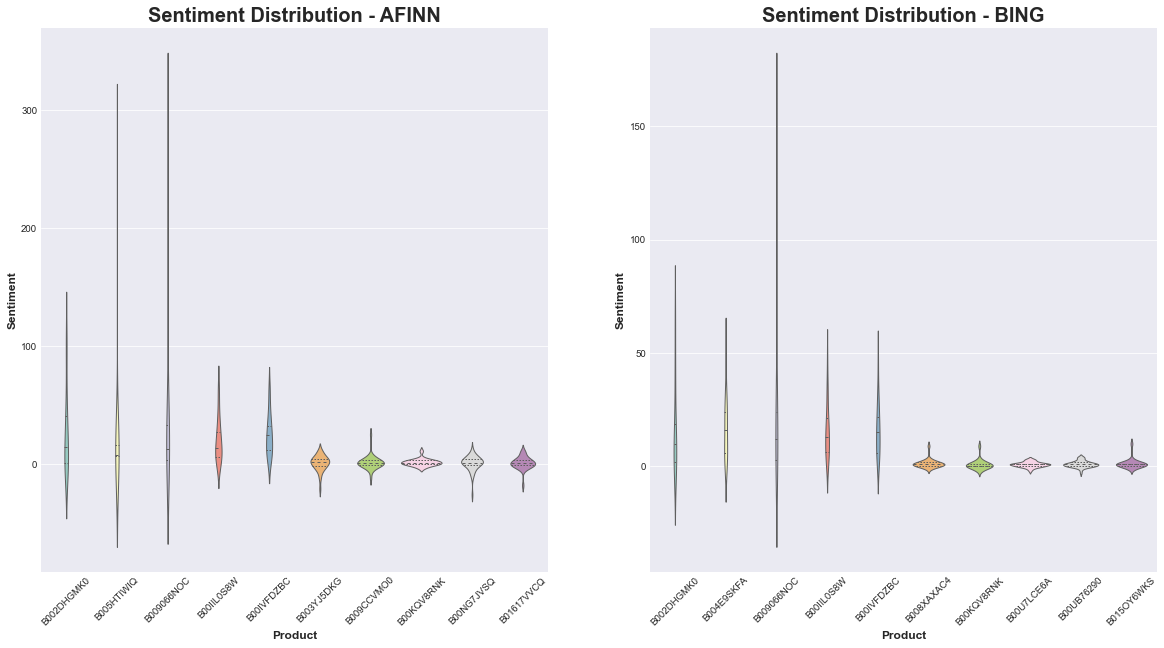

In [413]:
# Most Positive Products - Bar Chart (AFINN and BING)

# AFINN
# plot a violin plot for each product in prod_afinn_data using seaborn for sentiment afinn 
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.violinplot(x="asin", y="sentiment_afinn", data=prod_afinn_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45)

# BING
# plot a violin plot for each product in prod_bing_data using seaborn for sentiment bing
plt.subplot(1, 2, 2)
sns.violinplot(x="asin", y="sentiment_bing", data=prod_bing_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution - BING", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45);



# Least Positive Products - Bar Chart (AFINN and BING)

In [414]:
prod_bing_data[prod_bing_data.asin == "BOO2DHGMK0"]

,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand,new_review,new_title,new_desc,new_brand,sentiment_afinn,sentiment_bing


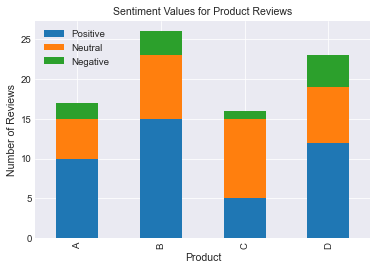

{'Product': ['A', 'B', 'C', 'D'],
 'Positive': [10, 15, 5, 12],
 'Neutral': [5, 8, 10, 7],
 'Negative': [2, 3, 1, 4]}

In [404]:
import matplotlib.pyplot as plt
import pandas as pd

# example dataframe with sentiment values for each product review
data = {'Product': ['A', 'B', 'C', 'D'],
        'Positive': [10, 15, 5, 12],
        'Neutral': [5, 8, 10, 7],
        'Negative': [2, 3, 1, 4]}
df = pd.DataFrame(data)

# plot stacked bar chart
ax = df.plot(x='Product', kind='bar', stacked=True)

# set plot title and labels
ax.set_title('Sentiment Values for Product Reviews')
ax.set_xlabel('Product')
ax.set_ylabel('Number of Reviews')

# show plot
plt.show()
data


### Tokenization

**Token and Tokenization**: 

**Stemming**:

**Lemmatizing**:

**Stop Words**: 


In [ ]:
# tokenize text data into words
from nltk.tokenize import word_tokenize

# tokenize text data into words and remove stop words and punctuation marks using NLTK library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# function to tokenize text data
def tokenize(text):
    # tokenize text data into words
    tokens = word_tokenize(text)
    # remove stop words and punctuation marks
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    tokens = [w for w in tokens if w.isalpha()]
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(w) for w in tokens]
    return tokens

In [ ]:
# Most Positive Words Used 

# Most Negative Words Used

# Word Cloud - Most Positive / Negative Words

### Using NRC for Sentiment Analysis

In [ ]:
# Bar Chart - NRC Frequency of Sentiments

# Bar Chart - most frequent words for each sentiment

Now we shall use the `TextBlob` package to perform sentiment analysis on the cleaned review text. 

1. For each review, calculate the polarity score, which is a float value between -1 and 1 that indicates the sentiment of the text. A positive score indicates positive sentiment, a negative score indicates negative sentiment, and a score close to zero indicates neutral sentiment.

2. Aggregate the polarity scores by product and calculate the mean or median polarity score for each product. This will give you an overall sentiment score for each product.

3. Analyze the results to see which products have the most positive or negative sentiment.

The below code does exactly that. It calculates the polarity score for each review using the Bing lexicon, aggregates the scores by product, and then prints the top 10 products with the highest sentiment scores. Note that the `PatternAnalyzer()` class is used as the sentiment analyzer to access the Bing lexicon.




In [251]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer


# Perform sentiment analysis
soft_data['polarity'] = soft_data['new_review'].apply(lambda text: TextBlob(text, analyzer=PatternAnalyzer()).sentiment.polarity)

# Aggregate sentiment scores by product
product_sentiment = soft_data.groupby('asin')['polarity'].mean()

# Print the top 10 products by sentiment score
print(product_sentiment.sort_values(ascending=False).head(10))


asin
B0012VI1ES    0.750000
B000WY1Q5M    0.716667
B00OSE74RG    0.630000
B00149YSUY    0.527500
B00132DENO    0.500000
B01DEG0SGC    0.485833
B017W85QUQ    0.474290
B004E564PW    0.460491
B00RKZKFUI    0.460256
B00JHN1MPI    0.457332
Name: polarity, dtype: float64


In [255]:
soft_data[soft_data.asin == 'B0012VI1ES'].loc[:,['title', 'reviewText', 'overall', 'polarity']].head(5)

,title,reviewText,overall,polarity
4253,Mavis Beacon Teaches Typing Platinum 20 - Old ...,great,4,0.8
4254,Mavis Beacon Teaches Typing Platinum 20 - Old ...,Its good. Used in class room setting with H.S...,5,0.7
4255,Mavis Beacon Teaches Typing Platinum 20 - Old ...,great,4,0.8
4256,Mavis Beacon Teaches Typing Platinum 20 - Old ...,Its good. Used in class room setting with H.S...,5,0.7


***
# Collaborative Filtering




## Non-negative Matrix Factorisation

## Deep Matrix Factorisation

## Neural Collaborative Filtering

***
# Content Based Filtering

## Using Review Text, Titles and Brand

***
# Hybrid Recommender Model

## Content Based & Collaborative Filtering

***
# Results and Conclusion